# Using XGBoost (on GPU) for Network Data Anomaly Detection

In this notebook, we'll train a GPU-accelerated XGBoost model (via the NVIDIA Rapids library) for detecting network intrusions using the KDD99 dataset.  We'll train two different models: 1) a binary classification model that predicts anomalous data as '1' and Normal data as '0', and 2) a mulit-class classification model that detects different types of anomalies.

##### (This notebook is inspired by an anomaly detection workshop I took through NVIDIA's Deep Learning Institute and I'd like to thank their team for putting together a well organized and informative workshop!)

In [1]:
# Import libraries
import os
from sys import exit
from time import time
from copy import copy
from collections import OrderedDict
from glob import glob
import gc
import pickle
from timeit import default_timer
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, roc_curve
from sklearn.datasets import fetch_kddcup99
import matplotlib.pyplot as plt

# Set numpy random seed
np.random.seed(42)

# Set Pandas' default dataframe display to show all columns
pd.set_option('display.max_columns', None)

## 1) Data exploration and preprocessing

The KDD99 dataset consists network packet data, with each entry being classified as either normal traffic, or an intrusion attempt.  The intrusions are categorized as Denial of Service (DoS), Remote to User (R2L), User to Root (U2R), and Probing (Probe). More info about the dataset can be found here:
https://kdd.ics.uci.edu/databases/kddcup99/task.html

In [2]:
# Download the full KDD99 dataset
# Note: This may take a few minutes if this is the first time downloading
# the dataset.  After the first download, it'll remain cached in data_dir.
data_dir = "./data/"
try:
    data, labels = fetch_kddcup99(data_home=data_dir, percent10=False, download_if_missing=True, as_frame=True, return_X_y=True)
except IOError:
    raise SkipTest("kddcup99 dataset can not be loaded.")
    exit()

In [3]:
# Display the first 5 rows from the raw data
data.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,b'tcp',b'http',b'SF',215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,b'tcp',b'http',b'SF',162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0
2,0,b'tcp',b'http',b'SF',236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,2,2,1,0,0.5,0,0,0,0,0
3,0,b'tcp',b'http',b'SF',233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,1,0,0,3,3,1,0,0.33,0,0,0,0,0
4,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0,0,0,0,1,0,0,4,4,1,0,0.25,0,0,0,0,0


In [4]:
# Display the first 5 rows from the labels
labels.head(5)

0    b'normal.'
1    b'normal.'
2    b'normal.'
3    b'normal.'
4    b'normal.'
Name: labels, dtype: object

Next, we'll define a label encoder so that we can map our classes to integers, for use when we train a multi-class classifier.

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(labels)
print(label_encoder.classes_)

[b'back.' b'buffer_overflow.' b'ftp_write.' b'guess_passwd.' b'imap.'
 b'ipsweep.' b'land.' b'loadmodule.' b'multihop.' b'neptune.' b'nmap.'
 b'normal.' b'perl.' b'phf.' b'pod.' b'portsweep.' b'rootkit.' b'satan.'
 b'smurf.' b'spy.' b'teardrop.' b'warezclient.' b'warezmaster.']


Let's look at what types of anomolies are in our dataset, as well as their frequency.

In [6]:
labels.value_counts()

b'smurf.'              2807886
b'neptune.'            1072017
b'normal.'              972781
b'satan.'                15892
b'ipsweep.'              12481
b'portsweep.'            10413
b'nmap.'                  2316
b'back.'                  2203
b'warezclient.'           1020
b'teardrop.'               979
b'pod.'                    264
b'guess_passwd.'            53
b'buffer_overflow.'         30
b'land.'                    21
b'warezmaster.'             20
b'imap.'                    12
b'rootkit.'                 10
b'loadmodule.'               9
b'ftp_write.'                8
b'multihop.'                 7
b'phf.'                      4
b'perl.'                     3
b'spy.'                      2
Name: labels, dtype: int64

We see that there are substantially more anomalies and normal data in this dataset.  Since there is a disproportionately larger number of anomalies than normal entries, the anomalies are no longer "anomalies" and are now the "normal", while the normal entries are acting as the anomalies.  We'll reaportion our data shortly to account for this skew.

To train our XGBoost model, we need to convert categorical values into numeric values.  For this dataset, each of the following features contains string values (e.g, service = 'http'): protocol_type, land, service, is_guest_login, is_host_login, flag, logged_in.  We'll use one-hot encoding to transform these categories into numerical values.

In [7]:
# One-hot encode categorical data
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']
cat_data = pd.get_dummies(data[cat_vars])
cat_data.head(5)

,protocol_type_b'icmp',protocol_type_b'tcp',protocol_type_b'udp',service_b'IRC',service_b'X11',service_b'Z39_50',service_b'aol',service_b'auth',service_b'bgp',service_b'courier',service_b'csnet_ns',service_b'ctf',service_b'daytime',service_b'discard',service_b'domain',service_b'domain_u',service_b'echo',service_b'eco_i',service_b'ecr_i',service_b'efs',service_b'exec',service_b'finger',service_b'ftp',service_b'ftp_data',service_b'gopher',service_b'harvest',service_b'hostnames',service_b'http',service_b'http_2784',service_b'http_443',service_b'http_8001',service_b'imap4',service_b'iso_tsap',service_b'klogin',service_b'kshell',service_b'ldap',service_b'link',service_b'login',service_b'mtp',service_b'name',service_b'netbios_dgm',service_b'netbios_ns',service_b'netbios_ssn',service_b'netstat',service_b'nnsp',service_b'nntp',service_b'ntp_u',service_b'other',service_b'pm_dump',service_b'pop_2',service_b'pop_3',service_b'printer',service_b'private',service_b'red_i',service_b'remote_job',service_b'rje',service_b'shell',service_b'smtp',service_b'sql_net',service_b'ssh',service_b'sunrpc',service_b'supdup',service_b'systat',service_b'telnet',service_b'tftp_u',service_b'tim_i',service_b'time',service_b'urh_i',service_b'urp_i',service_b'uucp',service_b'uucp_path',service_b'vmnet',service_b'whois',flag_b'OTH',flag_b'REJ',flag_b'RSTO',flag_b'RSTOS0',flag_b'RSTR',flag_b'S0',flag_b'S1',flag_b'S2',flag_b'S3',flag_b'SF',flag_b'SH',land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0


Notice for example, how the original 'protocol_type' feature has been split into 3 new features categories (protocol_type_icmp, protocol_type_tcp, and protocol_type_udp) with each category assigned a 1 or 0.

Now let's merge the new one-hot encoded features into our original dataset.

In [8]:
# Get the numeric data from our original dataset and exclude the categorical data
numeric_vars = list(set(data.columns.values.tolist()) - set(cat_vars))
numeric_data = data[numeric_vars].copy()

numeric_data.head(5)

,dst_host_srv_rerror_rate,srv_count,num_shells,diff_srv_rate,dst_host_serror_rate,serror_rate,src_bytes,rerror_rate,same_srv_rate,num_root,dst_host_same_src_port_rate,srv_diff_host_rate,wrong_fragment,duration,dst_host_srv_count,srv_rerror_rate,num_compromised,srv_serror_rate,hot,num_failed_logins,dst_host_same_srv_rate,count,dst_host_diff_srv_rate,num_access_files,su_attempted,dst_host_srv_diff_host_rate,dst_bytes,num_outbound_cmds,urgent,num_file_creations,dst_host_srv_serror_rate,root_shell,dst_host_rerror_rate,dst_host_count
0,0,1,0,0,0,0,215,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,45076,0,0,0,0,0,0,0
1,0,2,0,0,0,0,162,0,1,0,1,0,0,0,1,0,0,0,0,0,1,2,0,0,0,0,4528,0,0,0,0,0,0,1
2,0,1,0,0,0,0,236,0,1,0,0.5,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,1228,0,0,0,0,0,0,2
3,0,2,0,0,0,0,233,0,1,0,0.33,0,0,0,3,0,0,0,0,0,1,2,0,0,0,0,2032,0,0,0,0,0,0,3
4,0,3,0,0,0,0,239,0,1,0,0.25,0,0,0,4,0,0,0,0,0,1,3,0,0,0,0,486,0,0,0,0,0,0,4


In [9]:
# Concatenate the numeric and one-hot encoded categorical features
concat_numeric_data = pd.concat([numeric_data, cat_data], axis=1)

# Quick sanity check to make sure everything was concatenated correctly.
print("Raw data: ", data.shape)
print("Cagegorical data: ", cat_data.shape)
print("Numeric data: ", numeric_data.shape)
print("One-hot encoded categorical concat w/ numeric data: ", concat_numeric_data.shape)

Raw data:  (4898431, 41)
Cagegorical data:  (4898431, 92)
Numeric data:  (4898431, 34)
One-hot encoded categorical concat w/ numeric data:  (4898431, 126)


Looks good! We started with 41 features, 7 of which were categorical, leaving us with 34 numeric only features.  Those 7 categorical features were thus expanded to 92 numeric features using one-hot encoding. After concatenating the original numeric features with the newly created one-hot encoded features, we get 126 total numeric features (yay!).

Now let's split the data into into training and test datasets.

In [10]:
# Convert the labels to integers
int_labels = label_encoder.transform(labels)

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(concat_numeric_data,
                                                   int_labels,
                                                   test_size=0.25,
                                                   random_state=42)

In [11]:
# Sanity check the new datasets
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test:  ", x_test.shape)
print("y_test:  ", y_test.shape)

x_train:  (3673823, 126)
y_train:  (3673823,)
x_test:   (1224608, 126)
y_test:   (1224608,)


Now that we have our dataset preprocessed and split into our train and test sets, let's save it to disk for use later on with different models (e.g., an AutoEncoder, GAN, etc.).

In [38]:
def save_data():
    preprocessed_data = {
        'x_train': x_train,
        'y_train': y_train,
        'x_test': x_test,
        'y_test': y_test,
        'le': label_encoder
    }

    # pickle the preprocessed_data object as a binary file
    path = './data/preprocessed_data_full.pkl'
    output_fh = open(path, 'wb')
    pickle.dump(preprocessed_data, output_fh)
    output_fh.close()

#save_data()

## 2) Binary Classification Model

For this model, we'll classify network data as either anomalous ('1') or normal ('0').

We'll start by converting our labels to binary.  All of the "normal" lables will be converted to 0, and any other label will be converted to 1.

In [13]:
def create_binary_labels(label_encoder, labels):
    # Get the index number of the 'normal' label
    # Note: the dataset stores strings as byte strings so use b'myString'
    # to get the correct value.
    normal_indx = np.where(label_encoder.classes_ == b'normal.')[0][0]
    binary_labels = labels.copy()
    # Set all 'normal' labels to 1
    binary_labels[binary_labels != normal_indx] = 1
    # Set all other labels (anomalies) to 0
    binary_labels[binary_labels == normal_indx] = 0
    
    return binary_labels

binary_y_train = create_binary_labels(label_encoder, y_train)
binary_y_test = create_binary_labels(label_encoder, y_test)

# Sanity check our new binary labels
print(binary_y_train.sum())
print(binary_y_test.sum())


2944214
981436


In [14]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == b'normal.')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

binary_y_train = convert_label_to_binary(label_encoder, y_train)
binary_y_test = convert_label_to_binary(label_encoder, y_test)

# check how many anomalies are in our labels
print('Number of anomalies in y_train: ', binary_y_train.sum())
print('Number of anomalies in y_test:  ', binary_y_test.sum())

Number of anomalies in y_train:  2944214
Number of anomalies in y_test:   981436


Now we'll define our XGBoost hyperparameters.

In [15]:
params = {
    'num_rounds':    10, # how many interations to train on
    'max_depth':     8,
    'max_leaves':    2**8,
    'alpha':         0.9,
    'eta':           0.1,
    'gamma':         0.1,
    'learning_rate': 0.1,
    'subsample':     1,
    'reg_lambda':    1,
    'scale_pos_weight': 2,
    'tree_method':   'gpu_hist',
    'n_gpus':        1,
    'objective':     'binary:logistic',
    'verbose':       True
}

Before we train our model, we need to ensure the data in our dataframe is of type integer. The default datatype is of type object, so we'll update that.

In [16]:
print("DataFrame dtypes before converting: \n", x_train.dtypes)
x_train = x_train.astype('uint8')
x_test = x_test.astype('uint8')
print("\nDataFrame dtypes after converting: \n", x_train.dtypes)

DataFrame dtypes before converting: 
 dst_host_srv_rerror_rate    object
srv_count                   object
num_shells                  object
diff_srv_rate               object
dst_host_serror_rate        object
                             ...  
logged_in_1                  uint8
is_host_login_0              uint8
is_host_login_1              uint8
is_guest_login_0             uint8
is_guest_login_1             uint8
Length: 126, dtype: object

DataFrame dtypes after converting: 
 dst_host_srv_rerror_rate    uint8
srv_count                   uint8
num_shells                  uint8
diff_srv_rate               uint8
dst_host_serror_rate        uint8
                            ...  
logged_in_1                 uint8
is_host_login_0             uint8
is_host_login_1             uint8
is_guest_login_0            uint8
is_guest_login_1            uint8
Length: 126, dtype: object


Note:
- objective: either binary classification or multi-class classification.  For multi-class, use 'multi-softmax'
- tree_method: 'gpu_hist' uses histogram optimized approx. greedy algorithm.


Before we train the model, we'll need to convert our training and test data into a DMatrix data structure (provides better memory efficiency and training speed).

In [17]:
d_train = xgb.DMatrix(x_train, label=binary_y_train)
d_test = xgb.DMatrix(x_test, label=binary_y_test)
evals = [(d_test, 'test'), (d_train, 'train')]

Now it's time to start training our binary-classification XGBoost model!

In [18]:
train_start = time()
print("Training started at: ", train_start)

xgb_binary_model = xgb.train(params, d_train, params['num_rounds'], evals=evals)
train_end = time()

print("Training took %.2f seconds to complete." % (train_end - train_start))

Training started at:  1619138398.946971
[18:39:58] WARNING: ../include/xgboost/generic_parameters.h:38: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[18:39:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_rounds", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:40:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.59831	train-logloss:0.59830
[1]	test-logloss:0.52063	train-loglos

Now that we've trained our model, we'll set the probability score threshold value. A binary logistic classifier usually sets the value to 0.5 so that anything equal to or above that is assigned a value of 1 (anomaly), and anything below is assinged a value of 0 (normal).  (This is used to calculate accuracy)

In [19]:
threshold = 0.5
true_anomalies = binary_y_test.astype('uint8')
print("Number of true anomalies: ", true_anomalies.sum())

Number of true anomalies:  981436


In [20]:
# Use the trained model to predict anomalies on the test set
preds = xgb_binary_model.predict(d_test)

[18:40:01] WARNING: ../include/xgboost/generic_parameters.h:38: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


In [21]:
print(preds)
pred_labels = (preds > threshold).astype('uint8')
print(pred_labels)
print("Number of predicted anomalies: ", pred_labels.sum())

[0.17971508 0.82071775 0.17929706 ... 0.17971508 0.82071775 0.82071775]
[0 1 0 ... 0 1 1]
Number of predicted anomalies:  981459


Use the ratio of correct classifications to the total number of samples to calculate accuracy.  Note, this metric can be misleading for anomaly detection tasks where the classes are highly imbalanced (e.g., substantially more normal than anomalies).

In [22]:
accuracy = accuracy_score(true_anomalies, pred_labels)
print("Accuracy: ", accuracy)

Accuracy:  0.9997199103713188


Another metric that's better suited for measuring a model's performance  in the case of imbalanced classes, is the Area Under the Receiver Operating Charisteric (ROC) Curve (AUC).  A score of 1 means the model is performing perfectly.  A score of 0.5 means the model is performing as well as a random guess.  The AUC curve plots the True Positive Rate (TPR) - a measure of how often the prediction is correct - vs the False Positive Rate (FPR) - how often the prediction is incorrect when the value is in fact negative.

In [23]:
auc = roc_auc_score(true_anomalies, preds)
print("AUC: ", auc)

AUC:  0.9999602779343989


So it looks like our model is preforming quite well!
We can also look at a confusion matrix to help understand what's being misclassified (elements on the off-diagonal).

In [24]:
confusion_results = confusion_matrix(true_anomalies, pred_labels)

In [25]:
def plot_confusion_matrix(confusion_matrix, names=None, cmap=plt.cm.Purples):
    width, height = confusion_matrix.shape
    plt.figure(figsize=(10,10))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    if names:
        tick_marks = np.arange(len(names))
        plt.xticks(tick_marks, names, rotation=45)
        plt.yticks(tick_marks, names)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Anomaly')
    plt.tight_layout()
    
    for i in range(width):
        for j in range(height):
            plt.annotate(str(confusion_matrix[i][j]), xy=(i, j),
                         horizontalalignment='center',
                         verticalalignment='center')

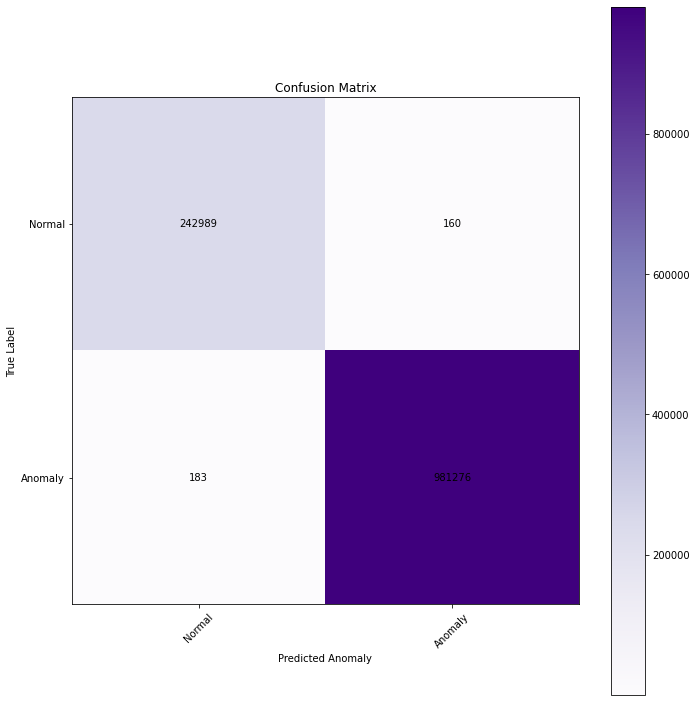

In [26]:
plot_confusion_matrix(confusion_results, ['Normal', 'Anomaly'])

Now let's plot the ROC AUC.

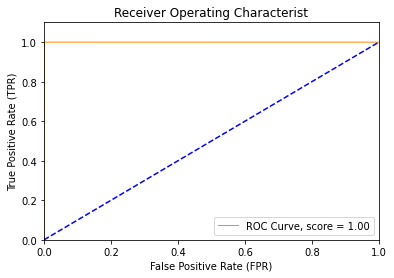

In [27]:
fpr, tpr, thresholds = roc_curve(true_anomalies, pred_labels)
roc_auc = roc_auc_score(true_anomalies, pred_labels)

def plot_roc_auc(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC Curve, score = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.title('Receiver Operating Characterist')
    plt.show()
    
plot_roc_auc(fpr, tpr, roc_auc)

We can also look at why our model is performing so well (or poorly) by looking at the features XGBoost ranked most important in determining a classification. This can be a great way of seeing which features are most likely linked to malicious acts!

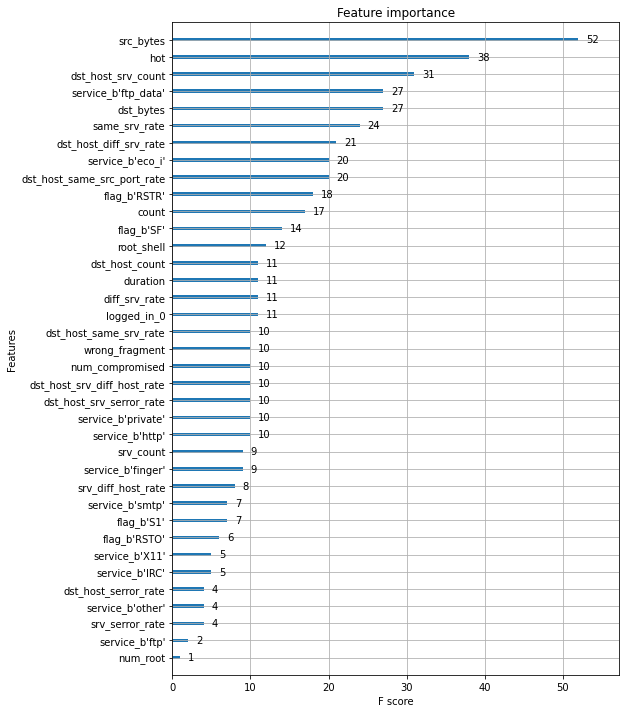

In [28]:
ax = xgb.plot_importance(xgb_binary_model)
fig = ax.figure
fig.set_size_inches(8, 12)

## 3) Multi-Class Classification Model

Now we'll look at not only classifying normal vs anomaly, but also predicting the type of anomaly.

In [29]:
num_classes = len(label_encoder.classes_)
params['objective'] = 'multi:softprob'
params['num_class'] = num_classes

In [30]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)
evals = [(d_test, 'test'), (d_train, 'train')]

In [31]:
train_start = time()
print("Training started at: ", train_start)

xgb_multi_class_model = xgb.train(params, d_train, params['num_rounds'], evals=evals)
train_end = time()

print("Training took %.2f seconds to complete." %(train_end - train_start))

Training started at:  1619138407.3472133
[18:40:07] WARNING: ../include/xgboost/generic_parameters.h:38: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[18:40:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_rounds", "scale_pos_weight", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:40:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-mlogloss:2.03072	train-mlogloss:2.03073
[1]	test-mlog

Now that the multi-class model is trained, let's evaluate it on the test dataset.

In [32]:
preds = xgb_multi_class_model.predict(d_test)

[18:40:25] WARNING: ../include/xgboost/generic_parameters.h:38: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


In [33]:
pred_labels = np.argmax(preds, axis=1)
print(pred_labels)

[11 18 11 ... 11 18 18]


In [34]:
true_labels = y_test
print(true_labels)

[11 18 11 ... 11 18 18]


In [35]:
accuracy_multi_class = accuracy_score(true_labels, pred_labels)
print("Multi-Class Model Accuracy Score: ", accuracy_multi_class)

Multi-Class Model Accuracy Score:  0.999692962972641


Again, we'll look at the confusion matrix to see what items are being misclassified.

In [36]:
cm_multi_class = confusion_matrix(true_labels, pred_labels)

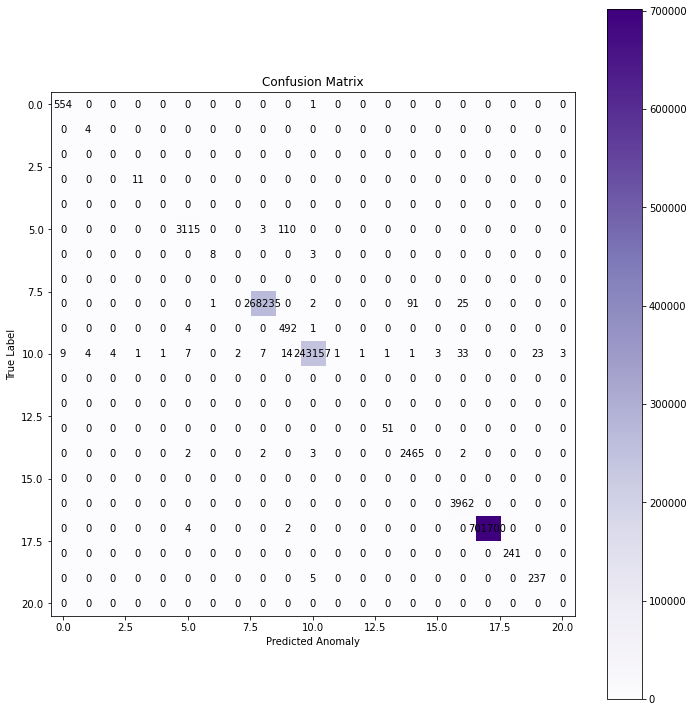

In [37]:
plot_confusion_matrix(cm_multi_class, names=None)

So as we see, the XGBoost model does very well at both binary and multi-class classification for the KDD99 dataset.
Something to keep in mind though with this model is that it performs well for a labeled dataset, but in the real world, we often have new threats that pop up (i.e., zero-day attacks), where a model like this may not fair as well since it will have never seen the new attack vector.  In this case, we'd want to use an unsupervised model like an AutoEncoder or GAN to detect anamolies.

Thanks for following along, hope you enjoyed it! <br>
-Gary